# Business Analytics : TP2

## Segmentation de Clientèle

L'idée, c'est de savoir segmenter la clienète d'une banque pour savoir quel stratégie va mieux fonctionner pour faire du marketing.

Pour se ça se base sur le dataset : https://www.kaggle.com/datasets/yufengsui/portuguese-bank-marketing-data-set
Celui-ci comprend les collones :
- age : age de la personne
- job : pour le travial de la personne en string
- marital : son status civil ["married", "single, "divorced"]
- education : niveau education ["tertiary", "primary", "secundary"]
- default : boolean pour dire s'il a des défaut de crédit
- balance : int pour dire l'argent qu'ils ont
- housing : boolean pour dire s'ils ont un empreint hypothéquaire
- loan : boolean pour dire si pret personnel
- contact : moyen de contact ?
- day : jours de la semaine du dernier contact par la banque [0,1,2,3,4,5,6] 
- month : dernier moids de contact ["january", "february", ...]
- duration : temps en second de la dernière communication avec la banque
- campaign : nombre de contact pendant 1 campagne
- pdays : nombre de jours depuis la dernière campagne (-1 si jamais contacté)
- previous : nombre de contact avant cette campagne
- poutcome : résultat de précédent campagne
- y : si client à pris plus de de chose à la banque

remarque en ouvrant le .csv fourni avec remarque qu'a encore plus de colone
on voit que day : c'est mon, tue,... et plus numéro et pdays c'est 999 si jamais été fait
mais y a en plus emp.var.rate, cons.price.id, euribor3m, nr.employed, ce collones on s'en fout donc va le drop directement

On va aussi supprimer y pour ne pas faire du supervised mais du non supervisé comme veut faire de la segmentation de clientèle et surtout pas trouver de correlation entre les y (enfin je pense)


In [1]:
#libraries
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
from sklearn.cluster import KMeans
from kneed import KneeLocator
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from kmodes.kprototypes import KPrototypes
from tqdm import tqdm
import numpy as np
import gower #pour distance mixte numerical et categorical
from prince import FAMD
from transformers import AutoTokenizer, AutoModel
import torch
from sentence_transformers import SentenceTransformer, util
from transformers import AutoTokenizer, pipeline, LlamaForCausalLM


### Chargment donné + nettoyage

In [2]:
dataset =  pd.read_csv("bank-additional-full.csv", delimiter=";") #lit le csv avec pandas


dataset = dataset.drop(columns=["y", "emp.var.rate", "cons.price.idx", "cons.conf.idx", "euribor3m", "nr.employed"]) #drop toutes les colonnes non utiles + y pour pas faire du supervised

dataset.head() #affiche head pour voir que pas de collone innutile en trop qu'on aurai pas vu

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent


In [3]:
dataset.info() #affiche info pour voir si y'a des missing values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   age          41188 non-null  int64 
 1   job          41188 non-null  object
 2   marital      41188 non-null  object
 3   education    41188 non-null  object
 4   default      41188 non-null  object
 5   housing      41188 non-null  object
 6   loan         41188 non-null  object
 7   contact      41188 non-null  object
 8   month        41188 non-null  object
 9   day_of_week  41188 non-null  object
 10  duration     41188 non-null  int64 
 11  campaign     41188 non-null  int64 
 12  pdays        41188 non-null  int64 
 13  previous     41188 non-null  int64 
 14  poutcome     41188 non-null  object
dtypes: int64(5), object(10)
memory usage: 4.7+ MB


Affiche ici le type colonnes. objet c'est pour string et voit que pas de collone qui devrait être en int qui est en string car par fois si on a 1.5 + " " alors deviens string pour toute la colone et faut forcer un strip + un cast pour eviter ce problème.

On va nettoyer maintenant les données invalide et extrême, pour géer les extrême, on supprimer pout toutes les colone numérique tout ce qui est hors du 1er et dernier percentile et scale tout ça entre 0 et 1 pour éviter effet de scalling qui est très important dans du non supervisé comme ici sinon sera biaisé à cause qu'une classe petit ou très grande

In [4]:
print(f"OG shape: {len(dataset)}")


# rempalce les "unknown" par des NaN ainsi sera plus facile a drop
# dataset.replace("unknown", pd.NA, inplace=True) #alors voulait les dégager mais retire 25% des données donc violent et puis peut être vrai que soit client n'a pas donné info ou banque ne l'a pas donc peut être sa propre catégorie
# drop tous les NaN
dataset = dataset.dropna() #supprimer toutes les lignes ou y a un NaN

print(f"after dropna {len(dataset)}")

dataset = dataset.drop_duplicates(keep='first') #supprimer les doublons
print(f"after drop duplicates {len(dataset)}")

scalers = {}

numeric_columns = dataset.select_dtypes(include=['float64', 'int64']).columns


for column in numeric_columns: #regarder pour toutes le coloones numérique
    lower_bound = dataset[column].quantile(0.01) #prend le 1er percentile
    upper_bound = dataset[column].quantile(0.99) #et le dernier
    # print(f"Values below lower bound in column '{column}': {dataset[column][dataset[column] < lower_bound].tolist()}")
    # print(f"Values above upper bound in column '{column}': {dataset[column][dataset[column] > upper_bound].tolist()}")
    dataset = dataset[(dataset[column] >= lower_bound) & (dataset[column] <= upper_bound)] # garde que les valeurs dans cette interval
    
    
    # scale tout entre 0 et 1
    scaler = MinMaxScaler()
    
    dataset[[column]] = scaler.fit_transform(dataset[[column]]) #fit transforme pour 1 et garder ce qu'il a fait pout transformer et récupérer après
    scalers[column] = scaler

print(f"after clipping outliers {len(dataset)}")

OG shape: 41188
after dropna 41188
after drop duplicates 41175
after clipping outliers 38941


On voit ici qu'on a clean les donné et on a perdu un petit quantité de client qui représente 5% des clients ce qui est encore acceptable vu qu'il en reste beaucoup.

Va maintenant one hot encode les string pour ainsi après faire la correlation entre toutes.

De plus, va supprimer la 1er collone de toutes celles qui vont être créer par le onehot encoe car on sait que la dernière c'est elle si toutes les autre valent 0 ce qui évite de mettre des dépendance pour la suite.

In [5]:
# Perform one-hot encoding on categorical columns
categorical_columns = dataset.select_dtypes(exclude=['int64', 'float64']).columns
dataset = pd.get_dummies(dataset, columns=categorical_columns, drop_first=True) #drop first pour supprimer et éviter de la redondance
print(f"after one-hot encoding {dataset.shape}")
print(dataset.columns)

after one-hot encoding (38941, 48)
Index(['age', 'duration', 'campaign', 'pdays', 'previous', 'job_blue-collar',
       'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired',
       'job_self-employed', 'job_services', 'job_student', 'job_technician',
       'job_unemployed', 'job_unknown', 'marital_married', 'marital_single',
       'marital_unknown', 'education_basic.6y', 'education_basic.9y',
       'education_high.school', 'education_illiterate',
       'education_professional.course', 'education_university.degree',
       'education_unknown', 'default_unknown', 'default_yes',
       'housing_unknown', 'housing_yes', 'loan_unknown', 'loan_yes',
       'contact_telephone', 'month_aug', 'month_dec', 'month_jul', 'month_jun',
       'month_mar', 'month_may', 'month_nov', 'month_oct', 'month_sep',
       'day_of_week_mon', 'day_of_week_thu', 'day_of_week_tue',
       'day_of_week_wed', 'poutcome_nonexistent', 'poutcome_success'],
      dtype='object')


On voit que ajouté pas mal de variante surtout pour les mois, bien une catégorie unknown qui pourrait gérer si le client ne veut rien donner comme info.

Va regarder si maintenant ces colonnes sont corrêlé entre elles

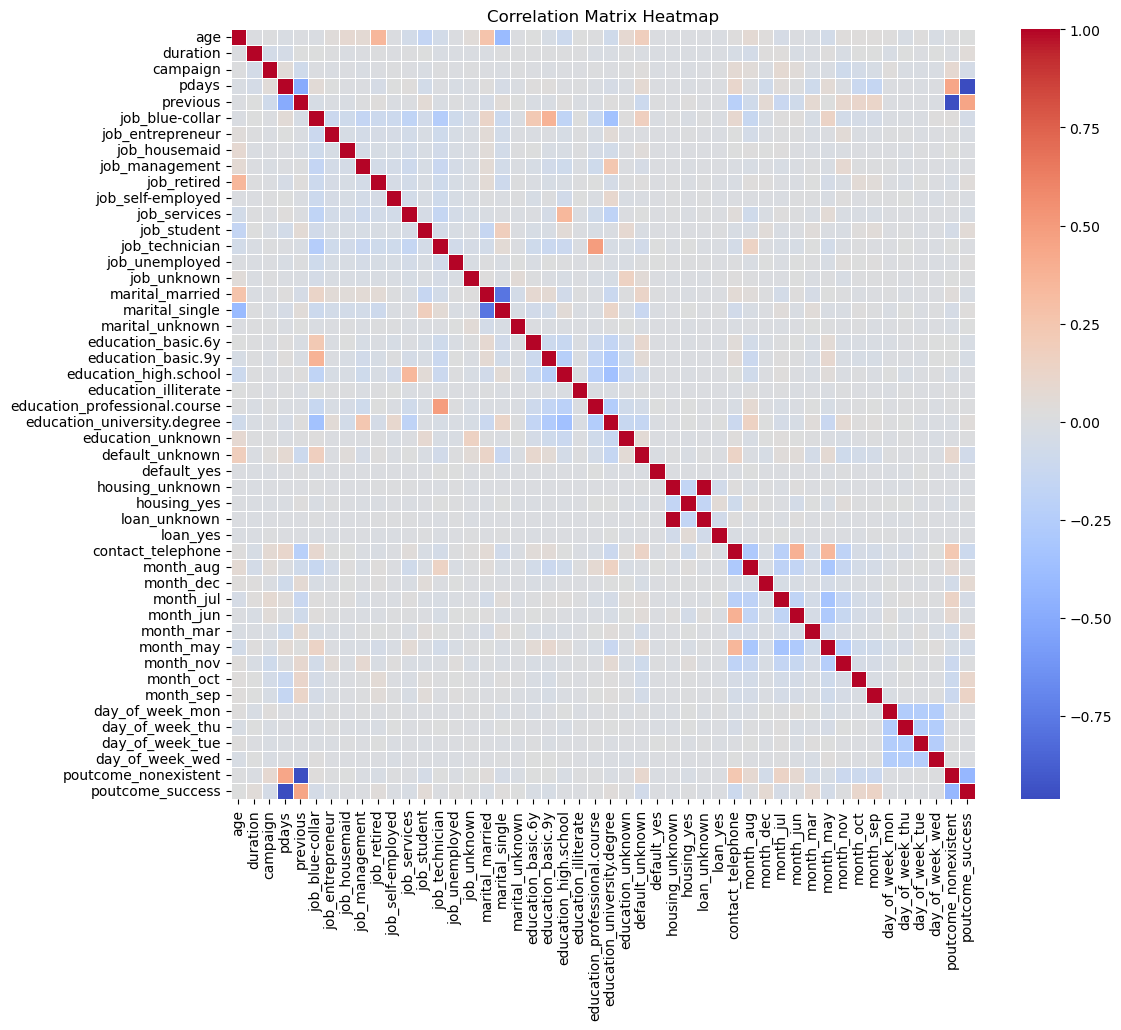

remove poutcome_success because correlate with pdays @ -0.9628947245398808
remove poutcome_nonexistent because correlate with previous @ -0.9520633578921406
remove loan_unknown because correlate with housing_unknown @ 1.0
after removing highly correlated columns (38941, 45)


In [6]:
# calcule matrice de confustion
correlation_matrix = dataset.corr()

# print
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title("Correlation Matrix Heatmap")
plt.show()

# supprimer si corrélation trop haute
threshold = 0.9  # limite à 0,9 pour que soit haut et peut les dégager
columns_to_remove = set()

# garde ce que c'est le cas
for i in range(len(correlation_matrix.columns)):
    for j in range(i + 1, len(correlation_matrix.columns)):
        if abs(correlation_matrix.iloc[i, j]) > threshold:
            colname = correlation_matrix.columns[j]
            cause = correlation_matrix.columns[i]
            columns_to_remove.add(colname)
            print(f"remove {colname} because correlate with {cause} @ {correlation_matrix.iloc[i, j]}")

# drop le set qu'on vient de créer avec les mauvais colonnes
dataset = dataset.drop(columns=columns_to_remove)
print(f"after removing highly correlated columns {dataset.shape}")

On voit bien que ceux qu'on a supprimer comme colonne était extrêment correlé et donc va juste simplifié notre dataset.

### Clustering
Après avoir traité donné, maintenant va pouvoir cluster. Cependant, quand on cluster on ne connait pas réelement combien de cluster il faut prendre, pour ça appliqué méthode du coode ou Elbow method

ou l'idée c'est de calculer pour un certains nombre de K prédéfini KMeans, la on regarde l'erreur WCSS qui correspond à au carré de la distance entre chaque point et sont centroïd pour tous les centroïd et on affiche sont évolution. Quand on remarque que d'un coup elle diminue moins, on dit que ce K la semble assez bien. 

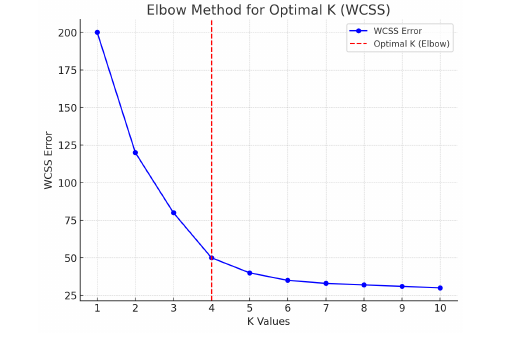

Existe une fonction KneeLocator qui permet de le faire. On a pas exactement même résultat mais proche comme c'est basé sur la vue, les critères de la fonction sont pas 100% les même mais reste proche.

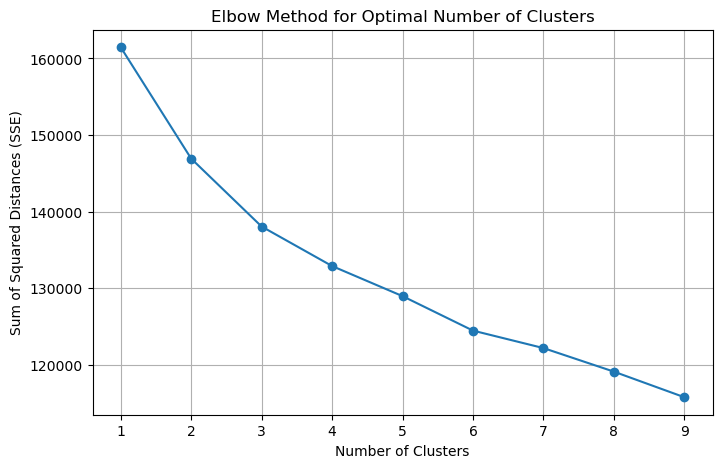

The optimal number of clusters is: 3


In [7]:
# List to store the sum of squared distances for each number of clusters
sse = []
diff = [] #si veut dérivé pour voir un peu plus clair sur l'évolution que diminue car revient que à la dérive si elle diminue.

test= 10

# test pour k de 1 a 9
for k in range(1, test):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(dataset)
    sse.append(kmeans.inertia_) #WCSS global directement calculé par kmeans reviens exactement la même chose que si on calcule a la main

    if k>1:
        derivative = abs(kmeans.inertia_-prev)
        diff.append(derivative)
    prev = kmeans.inertia_

# plot le graph
plt.figure(figsize=(8, 5))
plt.plot(range(1, test), sse, marker='o')
# plt.plot(range(1, 9), diff, marker='X') #montre pas dérivé ici
plt.xlabel('Number of Clusters')
plt.ylabel('Sum of Squared Distances (SSE)')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.xticks(range(1, test))
plt.grid()
plt.show()

#si on compare ave librairie kneed
knee_locator = KneeLocator(range(1, test), sse, curve="convex", direction="decreasing") #faut lui précisé que c'est convex pour avoir plus simple  ce qui devrait être le cas ou pres que et que ça diminue ce qui est le cas peut être pas à l'infinie mais pour 10 cnetroid oui + prend aussi les sse donc les loss
optimal_k = knee_locator.knee #permet de le récupérer facielment dans une variable

print(f"The optimal number of clusters is: {optimal_k}")

On voit que ici graphiquement pas trop simple car linéaire même si àpd de 3 diminue quand même beaucoup moins fort et surtout linéaire et donc peut comprendre pourquoi

Par contre pour la méthode est assez spéciale. Si on test pour les centre de 1 à 10, le meilleur c'est 3, si on test pour les centre de 1 à 25 le meilleur devient 9. Comme voit que courbe et connais pas le reste semble être assez fortement lié au nombre que montre. Après dans notre cas, 3 semble meilleur car veut trouver des segment clientèle et au moins y en aura au plus pourra faire quelque chose de groupé. Après si l'envie serait de faire quelque chose sur segment très particulier, peut tanter avec un K plus grand. Au moins cette méthode à permet de limiter le choix du nombre de K même si n'est pas pas infaible.

### Affichage des cluster
Après avoir calculer le nombre de cluster optimale, on peut les afficher et voir. On est obliger d'utiliser des méthode de réduction de dimensions comme PCA ou T-SNE pour savoir projeter comme sinon en + que 2 dimensions.

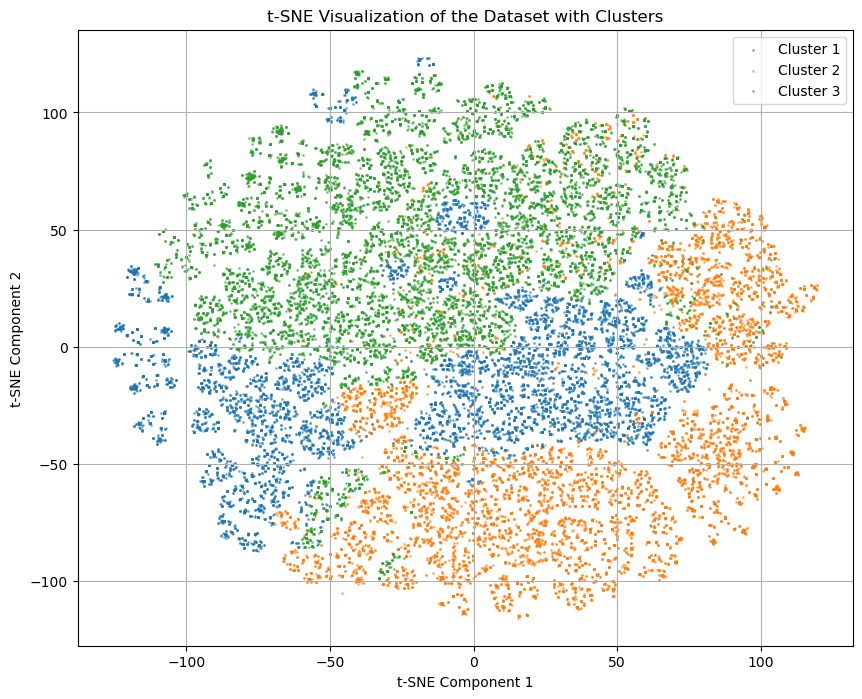

In [8]:
tsne = TSNE(n_components=2, random_state=42, n_jobs=-1) #fait t-SNE en 2D
tsne_results = tsne.fit_transform(dataset) # chope le résultat pour ou devrait se trouver en 2D

# créer les cluster avec kmeans
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
cluster_labels = kmeans.fit_predict(dataset) # prend label maintenant de chaque point du dataset sait que ordre sera garder

# le plot
plt.figure(figsize=(10, 8))
for cluster in range(optimal_k):
    cluster_points = tsne_results[cluster_labels == cluster] #afficher tout un culseter d'un coup
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], s=1, alpha=0.5, label=f"Cluster {cluster + 1}") #prens que 2 première dimension pour le plot en 2D

plt.title("t-SNE Visualization of the Dataset with Clusters")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.legend()
plt.grid()
plt.show()


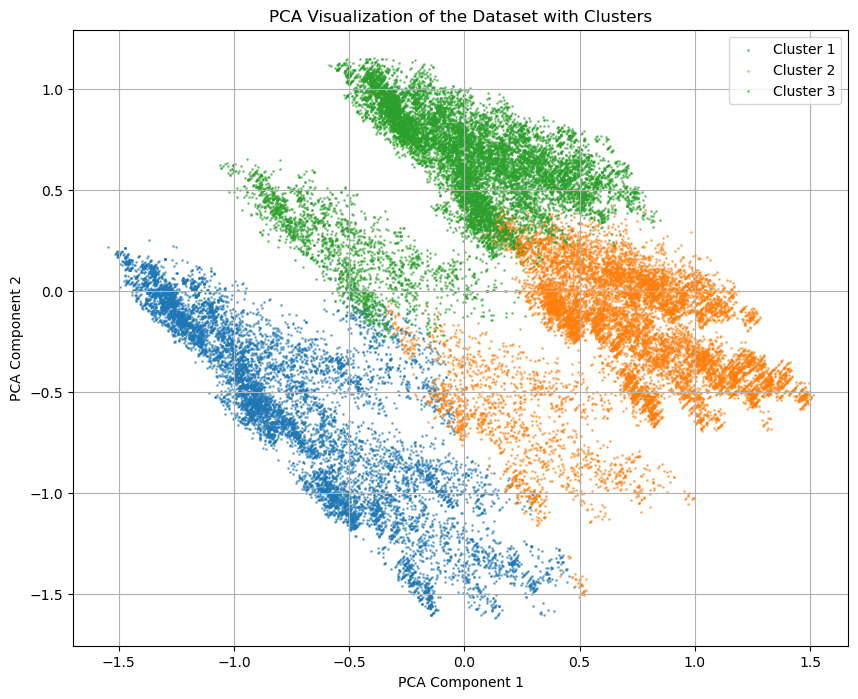

In [9]:

# pareil ave cPCA
pca = PCA(n_components=2)
pca_results = pca.fit_transform(dataset)

plt.figure(figsize=(10, 8))
for cluster in range(optimal_k):
    cluster_points = pca_results[kmeans.labels_ == cluster] #utilise les cluster d'avant
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], s=1, alpha=0.5, label=f"Cluster {cluster + 1}")

plt.title("PCA Visualization of the Dataset with Clusters")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend()
plt.grid()
plt.show()

En regardant, j'ai l'impression que PCA est un peu plus séparable que T-SNE mais montre que quand même pas mal de recouvrement.

Pour prouver ce recouvrement on peut utiliser le coefficient de silhouette.
D'après wikipedia :

>   
>The silhouette value is a measure of how similar an object is to its own cluster (cohesion) compared to other clusters (separation). The silhouette value ranges from −1 to +1, where a high value indicates that the object is well matched to its own cluster and poorly matched to neighboring clusters. If most objects have a high value, then the clustering configuration is appropriate. If many points have a low or negative value, then the clustering configuration may have too many or too few clusters. A clustering with an average silhouette width of over 0.7 is considered to be "strong", a value over 0.5 "reasonable", and over 0.25 "weak". However, with an increasing dimensionality of the data, it becomes difficult to achieve such high values because of the curse of dimensionality, as the distances become more similar.
>   

Donc en gros définit vraiment à quel point chaque points et bien similaire à ceux des autre cluster.

In [10]:

silhouette_avg = silhouette_score(dataset, kmeans.labels_) #pour ça exsite une fonction toute faite pour le calucle
print(f"The average silhouette score for {optimal_k} clusters is: {silhouette_avg}")

The average silhouette score for 3 clusters is: 0.08466162858772194


On obtient 0,0847 ce qui es très faible.

On avait vu aussi que la méthode du coude nous donnais un K optimale de 9, je vais un coup essayer de voir avec 9 si considérablement meilleur.

In [11]:
kmeans_9 = KMeans(n_clusters=9, random_state=42)
kmeans_9.fit(dataset)

silhouette_avg_9 = silhouette_score(dataset, kmeans_9.labels_)
print(f"The average silhouette score for 9 clusters is: {silhouette_avg_9}")

The average silhouette score for 9 clusters is: 0.09046837436281224


On voit que le coefficient de silhouette n'évolue quasimeent pas montrant que les nouveaux cluster n'aide pas beaucoup. On va donc continuer avec seulement 3 cluster pour avoir une moins à gérer et une inteprétation peut être plus simple

### Interprétation
Pour chaque cluster, on peut calculer quel varaible importe le plus pour y faire partie. Ainsi on peut savoir pourquoi la méthode à décide de séparer comme elle a fait.

In [12]:

for cluster in range(optimal_k): #pour chaque cluseter
    
    cluster_data = dataset[kmeans.labels_ == cluster] #réucpère data pour ce cluster
    
    
    cluster_means = cluster_data.mean() #prend moyenne du cluster pour les valeur numérique
    

    
    overall_means = dataset.mean() #prend la moyenne général
    
    
    feature_importance = (cluster_means - overall_means).abs() #regarde différnete
    
    
    sorted_features = feature_importance.sort_values(ascending=False) #trie par ordre décroissant
    
    
    print(f"Cluster {cluster + 1} Feature Importance:")
    for feature, importance in sorted_features.items(): #affiche
        print(f"{feature}: {importance:.4f}")
    print()


# A FAIRE DOIT RAJOUTER LES SCALLER POUR AVOIR VRAI VALEUR ET RETIRER ONE HOT ENCODING POUR AVOIR VALEUR DEPUIS LES DATA POUR SAVOIR EN MOYENNE TEL AGE, FAIT TEL TRUQUE ....

Cluster 1 Feature Importance:
marital_single: 0.6863
marital_married: 0.6115
age: 0.1258
education_university.degree: 0.0977
default_unknown: 0.0860
job_blue-collar: 0.0771
contact_telephone: 0.0596
education_basic.9y: 0.0425
education_high.school: 0.0400
job_technician: 0.0394
job_student: 0.0351
education_basic.6y: 0.0281
job_retired: 0.0257
job_management: 0.0256
month_jul: 0.0212
month_aug: 0.0179
job_entrepreneur: 0.0175
previous: 0.0168
job_housemaid: 0.0154
housing_yes: 0.0151
day_of_week_thu: 0.0114
month_nov: 0.0113
month_jun: 0.0099
pdays: 0.0087
month_mar: 0.0080
day_of_week_mon: 0.0059
day_of_week_tue: 0.0057
month_oct: 0.0040
job_unemployed: 0.0036
education_unknown: 0.0035
loan_yes: 0.0027
duration: 0.0024
month_may: 0.0023
education_professional.course: 0.0022
job_services: 0.0019
job_unknown: 0.0017
campaign: 0.0015
day_of_week_wed: 0.0013
job_self-employed: 0.0011
month_sep: 0.0010
marital_unknown: 0.0007
housing_unknown: 0.0005
education_illiterate: 0.0003
month_dec: 

### Résultat :
On voit ici la limite de Kmeans car tout simplement dans la partie catégoriel, remonte pour un même plusieurs catégorie possible. Cela n'est pas forcement dérangeant pour par exemple les métiers où ça se peut si on a un cluster de métier technique, on voit plusieurs métier technique remonté. Mais quand c'est l'état civil où il remonte seul et marié, il a remonté les 3/4 de personnes donc montre que ce n'est pas trop interessants.
Remonte en plus comparé à la moyenne la différence donc qunad faible, ne veut quasi rien dire par contre dès que commence à être grand veut dire qu ce cluster est différent des autres sur ce point

On va donc anaylser uniquement sur les valeurs qui était déjà des nombres où la leur interprétation semble plus simple à comprendre.

In [10]:
for cluster in range(optimal_k): #pour chaque cluseter
    cluster_data = dataset[kmeans.labels_ == cluster] #réucpère data pour ce cluster
    
    print(f"Cluster {cluster + 1} Means:")
    for col in numeric_columns:
        scaler = scalers[col]

        cluster_means = cluster_data.mean() #prend moyenne du cluster pour les valeur numérique
    

    
        overall_means = dataset.mean() #prend la moyenne général
        
        
        feature_importance = (cluster_means - overall_means).abs() #regarde différnete

        original_values = scaler.inverse_transform(cluster_data[[col]])


        cluster_means = original_values.mean()

        print(f"{col} variaiation of mean {feature_importance[col]:.4f} true Mean of cluster: {cluster_means:.4f}")

    print("\n")



Cluster 1 Means:
age variaiation of mean 0.1258 true Mean of cluster: 33.8071
duration variaiation of mean 0.0024 true Mean of cluster: 249.4962
campaign variaiation of mean 0.0015 true Mean of cluster: 2.3596
pdays variaiation of mean 0.0087 true Mean of cluster: 963.2764
previous variaiation of mean 0.0168 true Mean of cluster: 0.1766


Cluster 2 Means:
age variaiation of mean 0.0315 true Mean of cluster: 41.3585
duration variaiation of mean 0.0031 true Mean of cluster: 242.5974
campaign variaiation of mean 0.0057 true Mean of cluster: 2.4528
pdays variaiation of mean 0.0193 true Mean of cluster: 991.1177
previous variaiation of mean 0.0296 true Mean of cluster: 0.0838


Cluster 3 Means:
age variaiation of mean 0.0666 true Mean of cluster: 43.0431
duration variaiation of mean 0.0009 true Mean of cluster: 247.5545
campaign variaiation of mean 0.0038 true Mean of cluster: 2.3299
pdays variaiation of mean 0.0103 true Mean of cluster: 961.6703
previous variaiation of mean 0.0133 true Mea

### Résultat :

On voit maintenant que pour chaque les valeurs numérique ne sont pas très important et ne diffère pas beaucoup de la moyenne. sauf pour le cluster 1 avec l'age ou là c'est plus marqué.

On voit aussi que encodé 999 pour quand n'est pas encore arrivé alors que vrai valeur serait du style 1 ou 2 fait que beaucoup de valeur ce sont fait supprimer avec le système de percentile.

### KModes

On viens de voir que Kmeans été fortement limité quand il fallait gérer catégorielle et que pour un cluster il pouvait refaire monter des variable comme très différente mais reprend 90% de la population et ne veut juste rien dire. Cela vien du onehot encode et il y a moyen d'éviter ce problème en utilisant les K-Modes. Sur les catégories, elle va utilsier d'autre métrique que euclidienne qui ne fait pas de sens pour les catégories (pourtant utiliser par kmeans). Il va update les centroïd en utilisant les "mode" au lieu de la moyene pour les variable catégorielle

Remarque Kmode lui ne fonction pas bien dutout sur les variable continue et les intérprête comme des catégorie donc trouver une intermédiaire qui applique update Kmeans pour continuer et Kmode pour catégorielle.

Donc ce qu'il faut faire pour faire les deux c'est utiliser K-protype qui permet de faire du kmeans sur les numérique et kmode sur categorielle.

Comme montre l'article : https://www.semanticscholar.org/paper/CLUSTERING-LARGE-DATA-SETS-WITH-MIXED-NUMERIC-AND-Huang/d42bb5ad2d03be6d8fefa63d25d02c0711d19728#extracted


Pour ça faut reload le dataset sans one hot encode.

In [15]:
dataset =  pd.read_csv("bank-additional-full.csv", delimiter=";") #lit le csv avec pandas


dataset = dataset.drop(columns=["y", "emp.var.rate", "cons.price.idx", "cons.conf.idx", "euribor3m", "nr.employed"]) #drop toutes les colonnes non utiles + y pour pas faire du supervised

dataset.head() #affiche head pour voir que pas de collone innutile en trop qu'on aurai pas vu

print(f"OG shape: {len(dataset)}")


# rempalce les "unknown" par des NaN ainsi sera plus facile a drop
# dataset.replace("unknown", pd.NA, inplace=True) #alors voulait les dégager mais retire 25% des données donc violent et puis peut être vrai que soit client n'a pas donné info ou banque ne l'a pas donc peut être sa propre catégorie
# drop tous les NaN
dataset = dataset.dropna() #supprimer toutes les lignes ou y a un NaN

print(f"after dropna {len(dataset)}")

dataset = dataset.drop_duplicates(keep='first') #supprimer les doublons
print(f"after drop duplicates {len(dataset)}")

scalers = {}

numeric_columns = dataset.select_dtypes(include=['float64', 'int64']).columns


for column in numeric_columns: #regarder pour toutes le coloones numérique
    lower_bound = dataset[column].quantile(0.01) #prend le 1er percentile
    upper_bound = dataset[column].quantile(0.99) #et le dernier
    # print(f"Values below lower bound in column '{column}': {dataset[column][dataset[column] < lower_bound].tolist()}")
    # print(f"Values above upper bound in column '{column}': {dataset[column][dataset[column] > upper_bound].tolist()}")
    dataset = dataset[(dataset[column] >= lower_bound) & (dataset[column] <= upper_bound)] # garde que les valeurs dans cette interval
    
    
    # scale tout entre 0 et 1
    scaler = MinMaxScaler()
    
    dataset[[column]] = scaler.fit_transform(dataset[[column]]) #fit transforme pour 1 et garder ce qu'il a fait pout transformer et récupérer après
    scalers[column] = scaler

print(f"after clipping outliers {len(dataset)}")

OG shape: 41188
after dropna 41188
after drop duplicates 41175
after clipping outliers 38941


In [ ]:
#si On veut faire un Kprtopye
k_prototypes = KPrototypes(n_clusters=optimal_k, random_state=42, n_jobs=-1) #prend également comme avant un nombre de culster
categorical_indices = [dataset.columns.get_loc(col) for col in dataset.select_dtypes(exclude=['float64', 'int64']).columns] #prend toutes les collones qui ne sont pas int ou float pourrait aussis rechercher tout ce qui sont de type "object"
kmodes_clusters = k_prototypes.fit_predict(dataset, categorical=categorical_indices) #quand fit faut également donner les indices des colle qui sont catégorielle. 


### Application de la méthode du coude

Comme pour Kmeans, on peut appliquer la méthode du coude pour trouver le meilleur nombre de Cluster

100%|██████████| 9/9 [10:50<00:00, 72.29s/it]


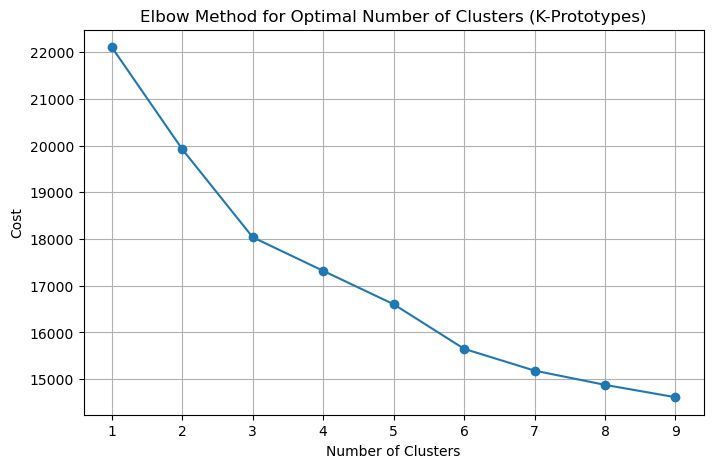

The optimal number of clusters is: 6


In [ ]:
cost = [] #stock les couts pour chaque

categorical_indices = [dataset.columns.get_loc(col) for col in dataset.select_dtypes(exclude=['float64', 'int64']).columns] #prend les indice de collones catégorielle

# test pour les différente nombre d cluster
for k in tqdm(range(1, 10)):
    k_prototypes = KPrototypes(n_clusters=k, random_state=42, n_jobs=-1)
    k_prototypes.fit(dataset, categorical=categorical_indices)
    cost.append(k_prototypes.cost_)  #d'après librarie c'est bien "Clustering cost, defined as the sum distance of all points to their respective cluster centroids." donc bien ce qu'on veut

# plot le graph d'évolution
plt.figure(figsize=(8, 5))
plt.plot(range(1, 10), cost, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Cost')
plt.title('Elbow Method for Optimal Number of Clusters (K-Prototypes)')
plt.xticks(range(1, 10))
plt.grid()
plt.show()

# utilise kneelocator pour trouver le le point de coude
knee_locator = KneeLocator(range(1, 10), cost, curve="convex", direction="decreasing")
optimal_k = knee_locator.knee

print(f"The optimal number of clusters is: {optimal_k}")

Avec cette méthode, on voit que le k optimal devrait être 6. Je ne vais pas tester comme l'autre avec 25, 50 ou 100 cluster possible vu que cette méthode et notablement plus lente.

On peut également calculer le coefficient de silhouette pour voir à quel point chaque élément d'un cluster se ressemble.

Remarque le calcule n'est pas aussi simple car silhouette_score ne permet pas de prendre en compte que y a catégorie et numérique. Donc faut passer une autre distance avant.
$$d_{Gower}( x,y) =\frac{1}{p}\sum _{j} s_{j}( x_{j} ,y_{j})$$

pas grande source mais normalement : 
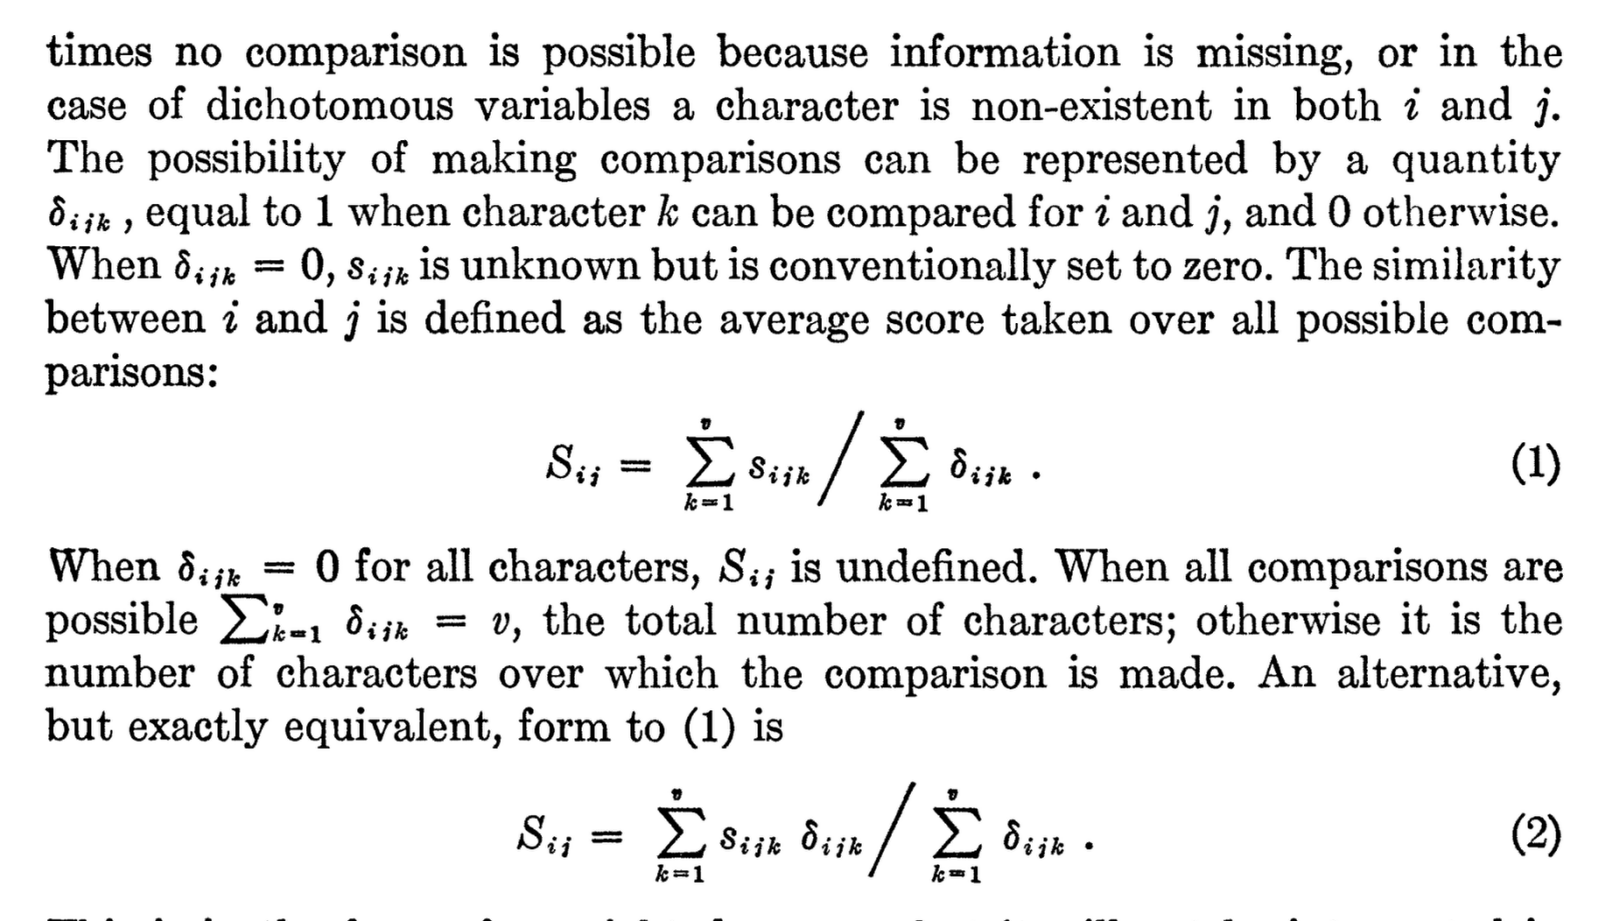


In [24]:
k_prototypes = KPrototypes(n_clusters=optimal_k, random_state=42, n_jobs=-1)
categorical_indices = [dataset.columns.get_loc(col) for col in dataset.select_dtypes(exclude=['float64', 'int64']).columns] #prend les indice de collones catégorielle
k_prototypes.fit(dataset, categorical=categorical_indices)

gower_distances = gower.gower_matrix(dataset) #en gros calcule la distance entre tout les points à l'avance

silhouette_avg = silhouette_score(gower_distances, k_prototypes.labels_, metric="precomputed") #regarde juste ceux qui sont dans le même et prend d'après la matrice la distance pour éviter de recalculer la distance mixte
print(f"The average silhouette score for {optimal_k} clusters is: {silhouette_avg}")

The average silhouette score for 6 clusters is: 0.10406216233968735


On trouve ainsi un coefficient de silouhette de 0,104 ce qui est un peu meilleur qu'avant montrant que la méthode fonctionne corrêctement.

### Affichage des cluster

Afficher les cluster en mix ici n'est pas une chose trivial. PCA ne support pas le mix entre numérique et catégorielle. Il est conseiller d'utiliser de la MFA multiple factor analysis of FAMD (factor analysisis of mixex data). Quant à TSNE, on peut lui donner une matrice de distance et on peut utiliser celle de gower comme avant.

### T-SNE

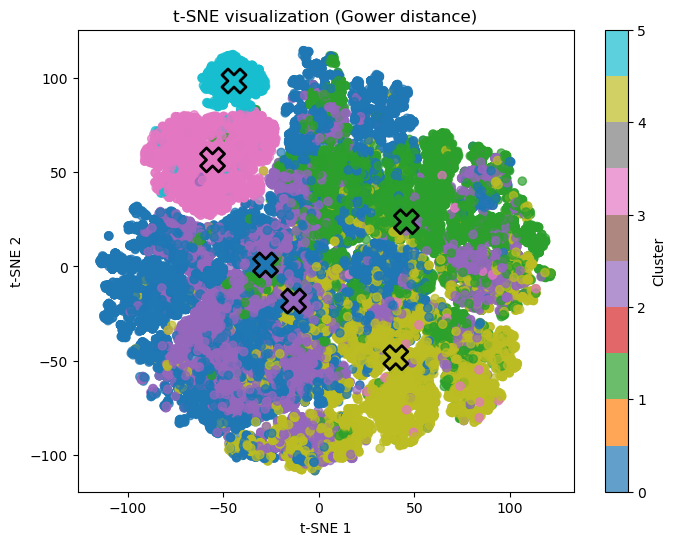

In [28]:
tsne = TSNE(metric="precomputed", init="random", random_state=42) #init random important pour precomputed
tsne_results = tsne.fit_transform(gower_distances) #donne le résultat pour TSNE

cluster_centers_tsne = np.vstack([
    tsne_results[k_prototypes.labels_ == k].mean(axis=0)
    for k in np.unique(k_prototypes.labels_)
])


plt.figure(figsize=(8,6))

# Plot samples
scatter = plt.scatter(
    tsne_results[:,0],
    tsne_results[:,1],
    c=k_prototypes.labels_,
    cmap="tab10",
    s=35,
    alpha=0.7
)

# Plot centers
plt.scatter(
    cluster_centers_tsne[:,0],
    cluster_centers_tsne[:,1],
    c=np.unique(k_prototypes.labels_),
    cmap="tab10",
    s=300,
    marker="X",
    edgecolor="black",
    linewidth=2,
    label="Centers"
)

plt.title("t-SNE visualization (Gower distance)")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.colorbar(scatter, label="Cluster")
plt.show()


On voit que le cluster roser et bleu sont assez bien séparable des autre par contre les autre, ils sont quand même pas mal de recouvrement entre eux.

### FAMD

In [ ]:
dataset.info() #doit bien vérifier d'avoir float et object/category sinon faut cast

<class 'pandas.core.frame.DataFrame'>
Index: 38941 entries, 0 to 41186
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   age          38941 non-null  float64
 1   job          38941 non-null  object 
 2   marital      38941 non-null  object 
 3   education    38941 non-null  object 
 4   default      38941 non-null  object 
 5   housing      38941 non-null  object 
 6   loan         38941 non-null  object 
 7   contact      38941 non-null  object 
 8   month        38941 non-null  object 
 9   day_of_week  38941 non-null  object 
 10  duration     38941 non-null  float64
 11  campaign     38941 non-null  float64
 12  pdays        38941 non-null  float64
 13  previous     38941 non-null  float64
 14  poutcome     38941 non-null  object 
dtypes: float64(5), object(10)
memory usage: 4.8+ MB


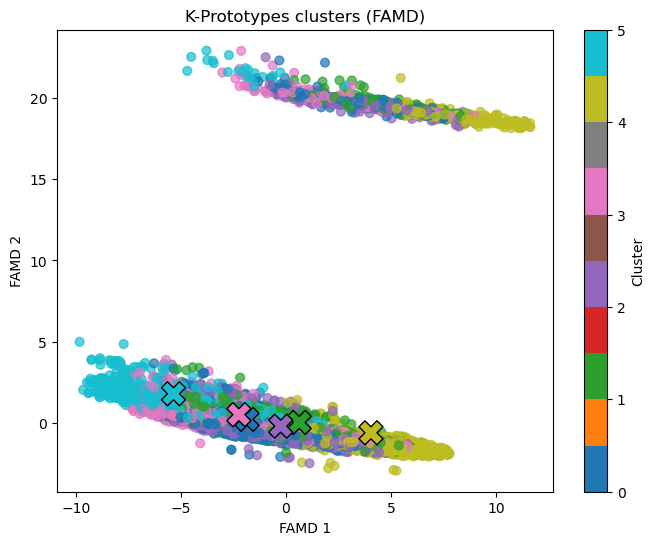

In [32]:
famd = FAMD(n_components=2, random_state=42)
famd_results = famd.fit_transform(dataset)

centers_famd = np.vstack([
    famd_results.values[k_prototypes.labels_ == k].mean(axis=0)
    for k in np.unique(k_prototypes.labels_)
])

plt.figure(figsize=(8,6))
plt.scatter(
    famd_results.iloc[:,0],
    famd_results.iloc[:,1],
    c=k_prototypes.labels_,
    cmap="tab10",
    s=40,
    alpha=0.7
)

plt.scatter(
    centers_famd[:,0],
    centers_famd[:,1],
    c=np.unique(k_prototypes.labels_),
    cmap="tab10",
    s=300,
    marker="X",
    edgecolor="black"
)

plt.xlabel("FAMD 1")
plt.ylabel("FAMD 2")
plt.title("K-Prototypes clusters (FAMD)")
plt.colorbar(label="Cluster")
plt.show()

On voit que la représentation est assez mauvais car on a de cluster en 2 parrtie qui sont vraiment fortement séparé. Aprs c'est attendu vu le score de silouhette

### PCA avec one-hot encode

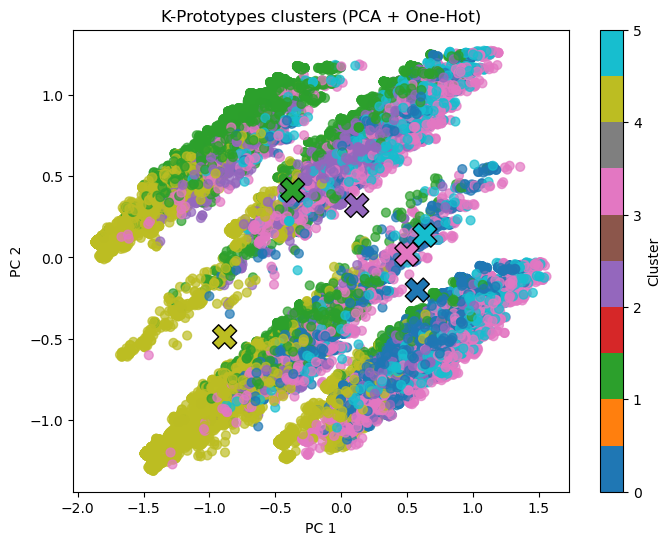

In [33]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

cat_cols = dataset.select_dtypes(exclude=['float64', 'int64']).columns
num_cols = dataset.select_dtypes(include=['float64', 'int64']).columns

preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(drop=None, handle_unknown="ignore"), cat_cols)
    ]
)

X_pca_input = preprocessor.fit_transform(dataset)
X_pca_input = X_pca_input.toarray()   # PCA needs dense

pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_pca_input)


labels = k_prototypes.labels_

centers_pca = np.vstack([
    X_pca[labels == k].mean(axis=0)
    for k in np.unique(labels)
])

plt.figure(figsize=(8,6))
plt.scatter(
    X_pca[:,0],
    X_pca[:,1],
    c=labels,
    cmap="tab10",
    s=40,
    alpha=0.7
)

plt.scatter(
    centers_pca[:,0],
    centers_pca[:,1],
    c=np.unique(labels),
    cmap="tab10",
    s=300,
    marker="X",
    edgecolor="black"
)

plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.title("K-Prototypes clusters (PCA + One-Hot)")
plt.colorbar(label="Cluster")
plt.show()

On voit que la séparabilité n'est toujours pas terrible avec cette méthode de visualisation. Mais c'est fortement lié avec quoi l'analyse.

### Autre remarque
conseil ces méthode là de la library prince en fonction du type de données :
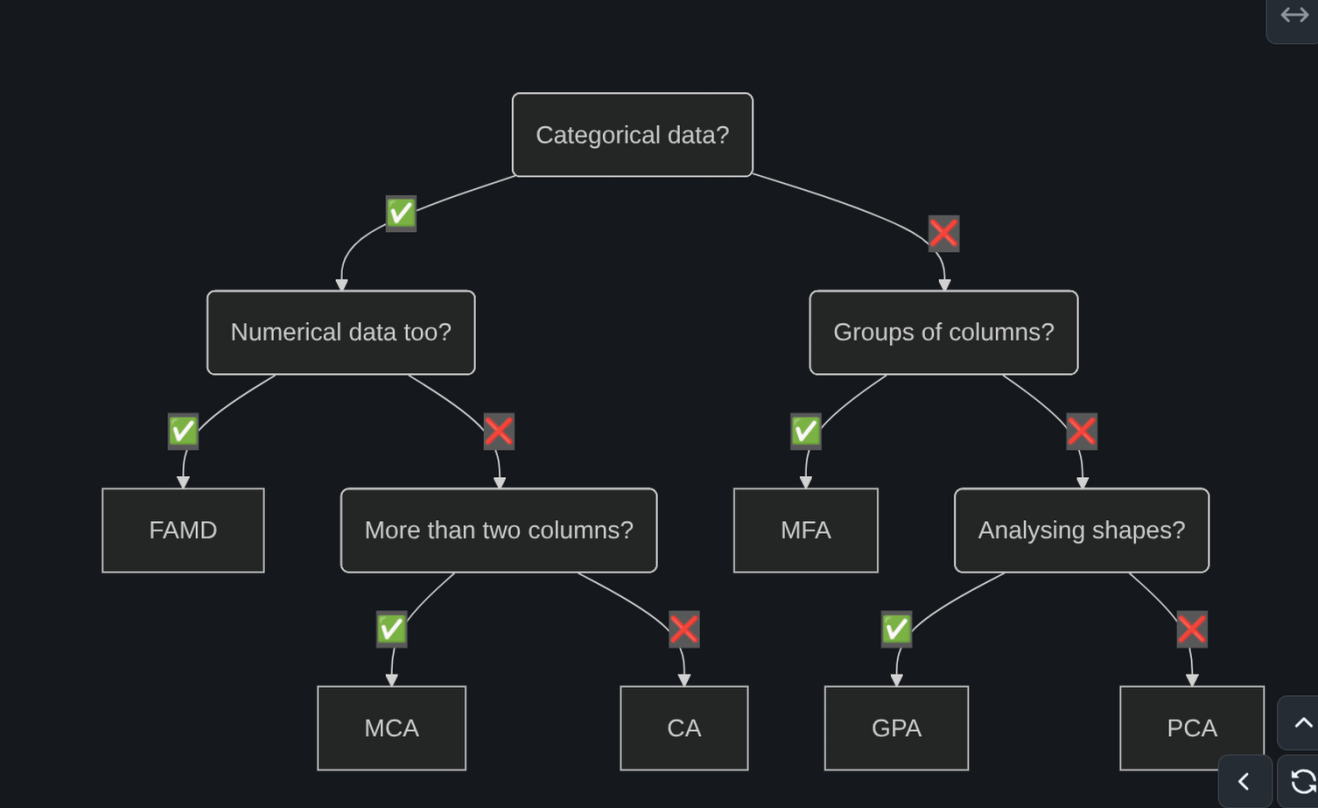

### Identification des points important de chaque cluster

On peut maintenant regarder pour chaque cluster ce qui est le plus important et voir s'il se differntie des autres.

In [42]:
numeric_columns = dataset.select_dtypes(include=['float64', 'int64']).columns
categorical_columns = dataset.select_dtypes(exclude=['float64', 'int64']).columns

for cluster in range(optimal_k): #pour chaque cluseter
    
    cluster_data = dataset[k_prototypes.labels_ == cluster] #réucpère data pour ce cluster
    

    print(f"Cluster {cluster + 1} :")

    for col in numeric_columns:
        

        scaler = scalers[col]



        cluster_means = cluster_data[col].mean() #prend moyenne du cluster pour les valeur numérique
    

    
        overall_means = dataset[col].mean() #prend la moyenne général
        
        
        feature_importance = abs(cluster_means - overall_means) #regarde différnete

        original_values = scaler.inverse_transform(cluster_data[[col]])


        cluster_means = original_values.mean()

        print(f"\t {col} variaition of mean {feature_importance:.4f} true Mean of cluster: {cluster_means:.4f} overal mean: {scaler.inverse_transform([[overall_means]])[0][0]:.4f}")

    
    for col in categorical_columns:
        cluster_mode = cluster_data[col].mode()[0]
        overall_mode = dataset[col].mode()[0]
        importance = int(cluster_mode != overall_mode)

        print(f"\t {col} mode difference: {importance} (Cluster mode: {cluster_mode}, Overall mode: {overall_mode})")

Cluster 1 :
	 age variaition of mean 0.0178 true Mean of cluster: 38.9918 overal mean: 39.8468
	 duration variaition of mean 0.0065 true Mean of cluster: 238.3031 overal mean: 246.4585
	 campaign variaition of mean 0.0029 true Mean of cluster: 2.3414 overal mean: 2.3793
	 pdays variaition of mean 0.0272 true Mean of cluster: 999.0000 overal mean: 971.9306
	 previous variaition of mean 0.0715 true Mean of cluster: 0.0000 overal mean: 0.1431
	 job mode difference: 0 (Cluster mode: admin., Overall mode: admin.)
	 marital mode difference: 0 (Cluster mode: married, Overall mode: married)
	 education mode difference: 0 (Cluster mode: university.degree, Overall mode: university.degree)
	 default mode difference: 0 (Cluster mode: no, Overall mode: no)
	 housing mode difference: 0 (Cluster mode: yes, Overall mode: yes)
	 loan mode difference: 0 (Cluster mode: no, Overall mode: no)
	 contact mode difference: 0 (Cluster mode: cellular, Overall mode: cellular)
	 month mode difference: 1 (Cluster m

### Résultat :

On remarque ici que les catégorie font du sens ce qui permet de mieux comprendre. On voit par exemple qu'un cluster di blue-colar donc travailleur en usine avec des études plus faible que la moyenne. C'est déjà ne bonne progression comparé à avant mais ça reste insufisant pour arriver vraiement faire de la grosse segementation. même si voit quand même déjà des tendance sortir.

## Partie 4 : Embedding
On va maintenant utiliser des modèles d'embeddings. L'idée c'est de créer un embedding d'une ligne complète. L'idée c'est qu'elle peut tout représenter en 1 seul vecteur en N dimensions.
Pour ça on va convertir une ligne en text et lem odèle va juste embed tout le text.

On accès au modèles suivants :
- nomic-embed-text-v1.5
- nomic-embed-text-v2-moe
- baai/bge-m3

Je vais en essayer plusieurs par la suite.

J'ai également testé par erreur : sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2 (qui s'avère être le meilleur)

In [5]:
model_name = "sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2"

device = "cuda" if torch.cuda.is_available() else "cpu" #définit gpu si dispo

model = SentenceTransformer(model_name, device=device)

print("max seq length:", model.get_max_seq_length())



max seq length: 128


Pour embedding, consigne à l'air de vouloir qu'on concatenne tout avec le nom et embedded comme pas gentils, c'est ce que je fait ici.

In [6]:
def row_to_text(row): #fonctoin pour tout fusioner avec le nom de la colone
    parts = []
    for col, val in row.items():
        if isinstance(val, float):
            parts.append(f"{col}: {val:.3f}")
        else:
            parts.append(f"{col}: {val}")
    return " | ".join(parts)


embed_dataset = dataset.copy()

categorical_columns = dataset.select_dtypes(exclude=['float64', 'int64']).columns #prend toutes les collones qui ne sont pas int ou float


embed_dataset['combined_text'] = embed_dataset[categorical_columns].apply(row_to_text, axis=1) #applique pour fusionner

X_embed = model.encode(embed_dataset['combined_text'].tolist(), show_progress_bar=True, batch_size=128, convert_to_numpy=True) #encode tout les texte en embedding

print(X_embed.shape)


Batches:   0%|          | 0/305 [00:00<?, ?it/s]

(38941, 384)


Maintenant qu'on a que des nombre peut refaire un Kmeans classique et tout ce qu'on a déjà fait avant. Donc méthode du coude, kmeans, visualisation.


### Méthode du coude

100%|██████████| 9/9 [00:01<00:00,  4.90it/s]


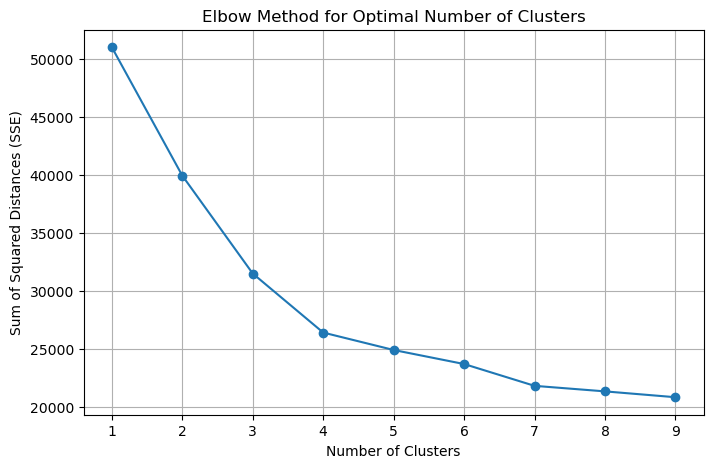

The optimal number of clusters is: 4


In [7]:
# List to store the sum of squared distances for each number of clusters
sse = []

test= 10

# test pour k de 1 a 9
for k in tqdm(range(1, test)):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_embed)
    sse.append(kmeans.inertia_) #WCSS global directement calculé par kmeans reviens exactement la même chose que si on calcule a la main

# plot le graph
plt.figure(figsize=(8, 5))
plt.plot(range(1, test), sse, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Sum of Squared Distances (SSE)')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.xticks(range(1, test))
plt.grid()
plt.show()

#si on compare ave librairie kneed
knee_locator = KneeLocator(range(1, test), sse, curve="convex", direction="decreasing") #faut lui précisé que c'est convex pour avoir plus simple  ce qui devrait être le cas ou pres que et que ça diminue ce qui est le cas peut être pas à l'infinie mais pour 10 cnetroid oui + prend aussi les sse donc les loss
optimal_k = knee_locator.knee #permet de le récupérer facielment dans une variable

print(f"The optimal number of clusters is: {optimal_k}")

On voit égalemnt que si on mets que de 1 à 9 alors voit que 4 optimale si plus monte à 7. Va préférer 4 pour éviter d'avoir trop a intepréter.

Attention à remarque dépend du modèle pour nomic V2 c'est 5.

Les autre c'est 4 l'optimale

### Calcule métrique silouhette

Comme avant peut mesure la métrique de silouhette

In [20]:
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
kmeans.fit_predict(X_embed) # prend label maintenant de chaque point du dataset
silhouette_avg = silhouette_score(X_embed, kmeans.labels_) #pour ça exsite une fonction toute faite pour le calucle
print(f"The average silhouette score for {optimal_k} clusters is: {silhouette_avg}")

The average silhouette score for 4 clusters is: 0.32249945402145386


On voit silouhete à 0,322 ce qui est bien meilleur qu'avant montrant que ce système d'embedding représente mieux les données

0,236 nomic V1
0,27 avec nomic V2
0,31 avec bge-m3

meilleur miniLM executé par erreur

### Visualisation avec TSNE suivi de PCA

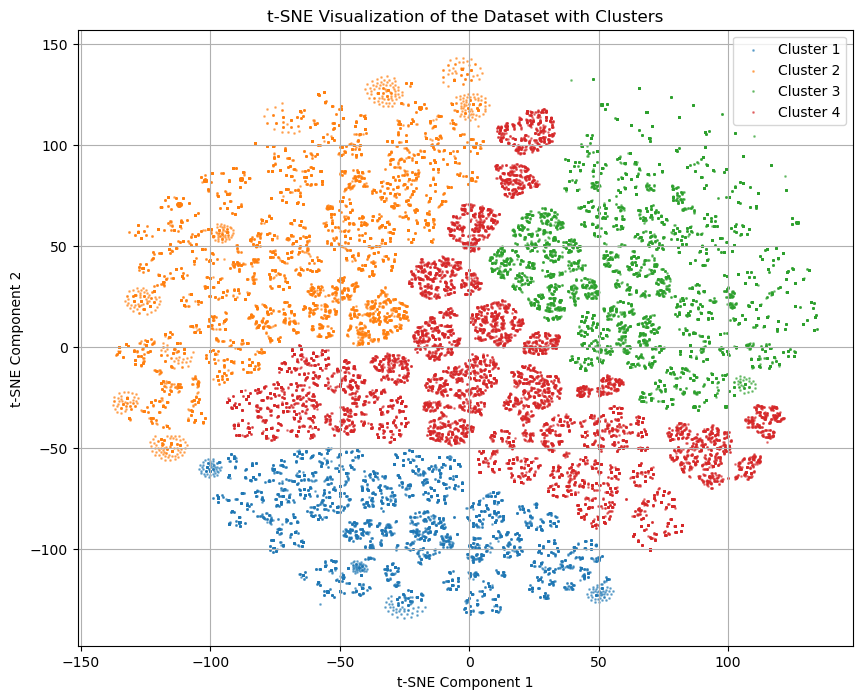

In [21]:
tsne = TSNE(n_components=2, random_state=42, n_jobs=-1) #fait t-SNE en 2D
tsne_results = tsne.fit_transform(X_embed) # chope le résultat pour ou devrait se trouver en 2D

# créer les cluster avec kmeans
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
cluster_labels = kmeans.fit_predict(X_embed) # prend label maintenant de chaque point du dataset sait que ordre sera garder
# le plot
plt.figure(figsize=(10, 8))
for cluster in range(optimal_k):
    cluster_points = tsne_results[cluster_labels == cluster] #afficher tout un culseter d'un coup
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], s=1, alpha=0.5, label=f"Cluster {cluster + 1}") #prens que 2 première dimension pour le plot en 2D

plt.title("t-SNE Visualization of the Dataset with Clusters")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.legend()
plt.grid()
plt.show()


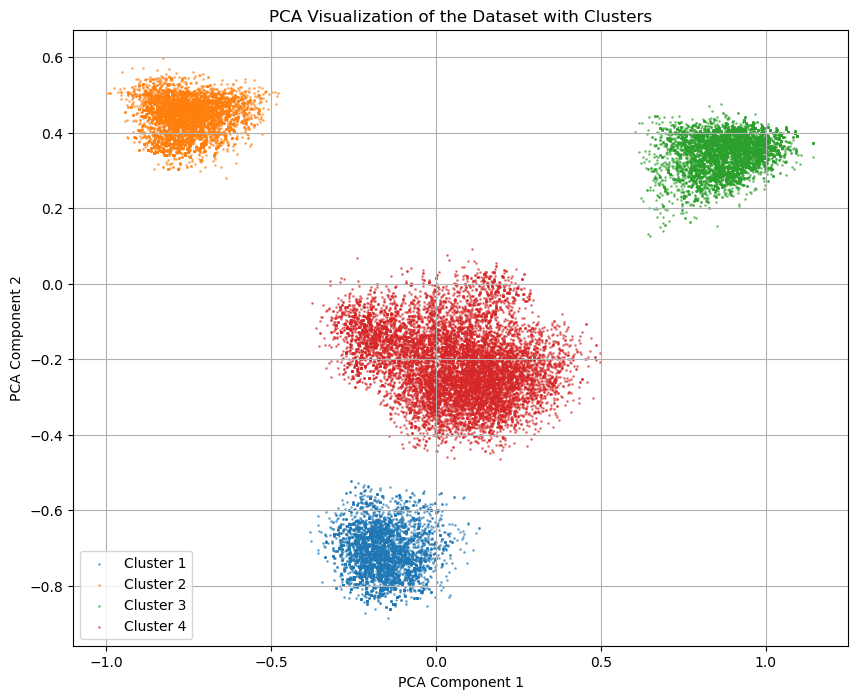

In [22]:
# pareil avec PCA
pca = PCA(n_components=2)
pca_results = pca.fit_transform(X_embed)

plt.figure(figsize=(10, 8))
for cluster in range(optimal_k):
    cluster_points = pca_results[kmeans.labels_ == cluster] #utilise les cluster d'avant
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], s=1, alpha=0.5, label=f"Cluster {cluster + 1}")

plt.title("PCA Visualization of the Dataset with Clusters")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend()
plt.grid()
plt.show()

### Résultat :

En effet, en regardant PCA et T-SNE voit que bien mieux séparer qu'avant et qu'expliquer pourquoi coef silouhette beaucoup plus grand

### Interprétations

Repasse par le dataset de base pour avoir les vrai valeur, cluster avec embedding mais revient à l'original pour savoir faire moyenne et autre

In [11]:
numeric_columns = dataset.select_dtypes(include=['float64', 'int64']).columns
categorical_columns = dataset.select_dtypes(exclude=['float64', 'int64']).columns


kmeans = KMeans(n_clusters=optimal_k, random_state=42)
cluster_labels = kmeans.fit_predict(X_embed) # prend label maintenant de chaque point du dataset sait que ordre sera garder

all_the_same = {col: {} for col in dataset.columns}  #dictionnaire pour stocker les valeurs moyennes ou mode de chaque cluster pour chaque colonne


for cluster in range(optimal_k): #pour chaque cluseter
    
    cluster_data = dataset[cluster_labels == cluster] #réucpère data pour ce cluster
    

    print(f"Cluster {cluster + 1} :")

    for col in numeric_columns:
        
        scaler = scalers[col]
        cluster_means = cluster_data[col].mean() #prend moyenne du cluster pour les valeur numérique
        overall_means = dataset[col].mean() #prend la moyenne général
        feature_importance = abs(cluster_means - overall_means) #regarde différnete

        original_values = scaler.inverse_transform(cluster_data[[col]])

        cluster_means = original_values.mean()

        all_the_same[col][cluster] = cluster_means

        print(f"\t {col} variaition of mean {feature_importance:.4f} true Mean of cluster: {cluster_means:.4f} overal mean: {scaler.inverse_transform([[overall_means]])[0][0]:.4f}")

    
    for col in categorical_columns:
        cluster_mode = cluster_data[col].mode()[0]
        overall_mode = dataset[col].mode()[0]
        importance = int(cluster_mode != overall_mode)

        all_the_same[col][cluster] = cluster_mode

        print(f"\t {col} mode difference: {importance} (Cluster mode: {cluster_mode}, Overall mode: {overall_mode})")

print(all_the_same)

Cluster 1 :
	 age variaition of mean 0.0265 true Mean of cluster: 38.5772 overal mean: 39.8468
	 duration variaition of mean 0.0056 true Mean of cluster: 239.4545 overal mean: 246.4585
	 campaign variaition of mean 0.0015 true Mean of cluster: 2.3983 overal mean: 2.3793
	 pdays variaition of mean 0.0005 true Mean of cluster: 971.4366 overal mean: 971.9306
	 previous variaition of mean 0.0071 true Mean of cluster: 0.1289 overal mean: 0.1431
	 job mode difference: 1 (Cluster mode: technician, Overall mode: admin.)
	 marital mode difference: 0 (Cluster mode: married, Overall mode: married)
	 education mode difference: 1 (Cluster mode: professional.course, Overall mode: university.degree)
	 default mode difference: 0 (Cluster mode: no, Overall mode: no)
	 housing mode difference: 0 (Cluster mode: yes, Overall mode: yes)
	 loan mode difference: 0 (Cluster mode: no, Overall mode: no)
	 contact mode difference: 0 (Cluster mode: cellular, Overall mode: cellular)
	 month mode difference: 0 (Clu

### Résultat :
On voit que les cluster sont mieux séparé cependant je n'arrive pas encore à leur trouvé des grande explications. J'ai l'impression que la banque actuellement contact toutes les personne du même secteur le même jour. Sinon oui il arrive un peu à faire des cluster différent en fonction de la professions. Mais je ne vois pas trop on va pouvoir le faire vendre plus de chose.

## Question 5 : analyse business

Maintenant qu'on a trouver une méthode pour faire du clustering, on va l'utiliser pour donner une interprétation business dessus.

L'idée c'est qu'on va utiliser le cluster avec les embeddings qui avait le coefficient de silouhette le plus élevé et que ces 4 cluster sont quand même un peu explicable pour trouver autre chose.


### 1ère analyse : regarder la parte d'achat dans un cluster

Pour ça va recharger le dataset original et utiliser les cluster.

In [37]:
dataset_og =  pd.read_csv("bank-additional-full.csv", delimiter=";") #lit le csv avec pandas


dataset_og = dataset_og.drop(columns=["emp.var.rate", "cons.price.idx", "cons.conf.idx", "euribor3m", "nr.employed"]) #drop toutes les colonnes non utiles + y pour pas faire du supervised

dataset_og = dataset_og.dropna() #supprimer toutes les lignes ou y a un NaN

dataset_og = dataset_og.drop_duplicates(keep='first') #supprimer les doublons


scalers = {}

numeric_columns = dataset_og.select_dtypes(include=['float64', 'int64']).columns

dataset_og['y'] = dataset_og['y'].replace({'yes': 1, 'no': 0})



for column in numeric_columns: #regarder pour toutes le coloones numérique
    lower_bound = dataset_og[column].quantile(0.01) #prend le 1er percentile
    upper_bound = dataset_og[column].quantile(0.99) #et le dernier
    # print(f"Values below lower bound in column '{column}': {dataset[column][dataset[column] < lower_bound].tolist()}")
    # print(f"Values above upper bound in column '{column}': {dataset_og[column][dataset_og[column] > upper_bound].tolist()}")
    dataset_og = dataset_og[(dataset_og[column] >= lower_bound) & (dataset_og[column] <= upper_bound)] # garde que les valeurs dans cette interval
    
    
    # scale tout entre 0 et 1
    scaler = MinMaxScaler()
    dataset_og[[column]] = scaler.fit_transform(dataset_og[[column]]) #fit transforme pour 1 et garder ce qu'il a fait pout transformer et récupérer après


#pour chaque cluster

for cluster in range(optimal_k): #pour chaque cluseter
    cluster_data = dataset_og[cluster_labels == cluster] #réucpère data pour ce cluster

    print(f"Cluster {cluster + 1} taux de souscription: {cluster_data['y'].mean()*100:.2f}% ({len(cluster_data)} samples)")

    cols = ["housing", "loan"]
    for col in cols:
        value_counts = cluster_data[col].value_counts()
        for value, count in value_counts.items():
            print(f"\t{col} - {value}: {count} ({count / len(cluster_data) * 100:.2f}%)")
    

Cluster 1 taux de souscription: 9.98% (6480 samples)
	housing - yes: 3480 (53.70%)
	housing - no: 2865 (44.21%)
	housing - unknown: 135 (2.08%)
	loan - no: 5394 (83.24%)
	loan - yes: 951 (14.68%)
	loan - unknown: 135 (2.08%)
Cluster 2 taux de souscription: 12.14% (9954 samples)
	housing - yes: 5308 (53.33%)
	housing - no: 4433 (44.53%)
	housing - unknown: 213 (2.14%)
	loan - no: 8109 (81.46%)
	loan - yes: 1632 (16.40%)
	loan - unknown: 213 (2.14%)
Cluster 3 taux de souscription: 6.26% (8916 samples)
	housing - yes: 4527 (50.77%)
	housing - no: 4159 (46.65%)
	housing - unknown: 230 (2.58%)
	loan - no: 7369 (82.65%)
	loan - yes: 1317 (14.77%)
	loan - unknown: 230 (2.58%)
Cluster 4 taux de souscription: 10.79% (13591 samples)
	housing - yes: 7052 (51.89%)
	housing - no: 6187 (45.52%)
	housing - unknown: 352 (2.59%)
	loan - no: 11243 (82.72%)
	loan - yes: 1996 (14.69%)
	loan - unknown: 352 (2.59%)


/tmp/ipykernel_631629/4018871387.py:15: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  dataset_og['y'] = dataset_og['y'].replace({'yes': 1, 'no': 0})


On voit avec ça que le cluster 3 a beaucoup moins acheter que les autre pourtant c'est seulement le 2e plus petit.

D'après l'interprétation :

Cluster 3 :

- age variaition of mean 0.0041 true Mean of cluster: 39.6523 overal mean: 39.8468
- duration variaition of mean 0.0046 true Mean of cluster: 252.2359 overal mean: 246.4585
- campaign variaition of mean 0.0010 true Mean of cluster: 2.3666 overal mean: 2.3793
- pdays variaition of mean 0.0156 true Mean of cluster: 987.4240 overal mean: 971.9306
- previous variaition of mean 0.0123 true Mean of cluster: 0.1184 overal mean: 0.1431
- job mode difference: 1 (Cluster mode: blue-collar, Overall mode: admin.)
- marital mode difference: 0 (Cluster mode: married, Overall mode: married)
- education mode difference: 1 (Cluster mode: basic.9y, Overall mode: university.degree)
- default mode difference: 0 (Cluster mode: no, Overall mode: no)
- housing mode difference: 0 (Cluster mode: yes, Overall mode: yes)
- loan mode difference: 0 (Cluster mode: no, Overall mode: no)
- contact mode difference: 0 (Cluster mode: cellular, Overall mode: cellular)
- month mode difference: 0 (Cluster mode: may, Overall mode: may)
- day_of_week mode difference: 1 (Cluster mode: wed, Overall mode: thu)
- poutcome mode difference: 0 (Cluster mode: nonexistent, Overall mode: nonexistent)

La grosse différence, c'est que c'est des blue-collar donc travailleur manuel donc soit comprend moins bien ce que la banque veut donc faire une publicité plus claire pour qu'ils comprennent soit gagne pas assez d'argent pour que les offre de la banque lui semble nécessaire.

Je pense plus sur la théorie de gagne pas assez d'argent pour se permettre d'autre service car ils ont en moyenne même % de crédit hypothéquaire et auto que les autre cluster.


Pourrait aussi penser dans l'autre sens comme pour le cluster 2, il est le plus populaire mais avec que 12%, il y a peut être moyen d'arriver à vendre plus dans ce cluster pour faire plus d'argent.

C'est un cluster qui ces caractéristiques :
- age variaition of mean 0.0342 true Mean of cluster: 38.2059 overal mean: 39.8468
- duration variaition of mean 0.0039 true Mean of cluster: 241.5629 overal mean: 246.4585
- campaign variaition of mean 0.0026 true Mean of cluster: 2.4133 overal mean: 2.3793
- pdays variaition of mean 0.0091 true Mean of cluster: 962.9079 overal mean: 971.9306
- previous variaition of mean 0.0075 true Mean of cluster: 0.1580 overal mean: 0.1431
- job mode difference: 0 (Cluster mode: admin., Overall mode: admin.)
- marital mode difference: 0 (Cluster mode: married, Overall mode: married)
- education mode difference: 0 (Cluster mode: university.degree, Overall mode: university.degree)
- default mode difference: 0 (Cluster mode: no, Overall mode: no)
- housing mode difference: 0 (Cluster mode: yes, Overall mode: yes)
- loan mode difference: 0 (Cluster mode: no, Overall mode: no)
- contact mode difference: 0 (Cluster mode: cellular, Overall mode: cellular)
- month mode difference: 0 (Cluster mode: may, Overall mode: may)
- day_of_week mode difference: 1 (Cluster mode: mon, Overall mode: thu)
- poutcome mode difference: 0 (Cluster mode: nonexistent, Overall mode: nonexistent)

Montrant que c'est personne instruite qui est souvent correllé à l'argent qu'ils font. Donc il y a les fond pour se permettre d'autre produit de la banque. Juste arrivé à leur prouvé que c'est utile et veut pas le refiler des chose innutile.

#### Strategie de marketing :
Je pense qu'une double statégie de marketing pourrait être interessante.

Une qui vise à simplifié et explique plus simplement pour les travailleur ce que la banque et fait et ce qu'il peuvent en gagner pour que le segment travailleur en % soit plus représenté

D'un autre côté une campagne vers les personne plus instruite expliquant corrêctement ce que la banque fait car il ne connaissant en expliquant plus en détail.

Tout ça possible comme campagne par téléphone et pas une seul pub à la TV.

#### Amélioration

Gagner sur les marché des travailleur n'est peut être pas le plus rentable car ils ne devront pas forcement avoir le plus d'argent au monde mais ça fait quand même une clientèle supplémentaire. Par contre sur le segment 2, la il peut être intessant comme éducation est correlé à argent alors pourrait arrivé que vend produit à eux et peuvent se le permettre.

### Generation d'une description pour chaque cluster

Pour ça on va se baser sur un LLM et ce que j'ai déjà écrit au par avant pour chaque cluster avoir un phrase qui la résume. 

Je vois pas intérèt à génerer ça par IA comme y en a que 4 et ainsi peut vérifier sois même si ne dit pas n'importe quoi.

In [10]:
model_name = "NousResearch/Hermes-3-Llama-3.2-3B"
tokenizer = AutoTokenizer.from_pretrained(model_name)

model = LlamaForCausalLM.from_pretrained( #force le chargent en 4Bit comme la doc le souhaite
    model_name,
    torch_dtype=torch.float16,
    device_map="auto",
    load_in_8bit=False,
    load_in_4bit=True,
)

`torch_dtype` is deprecated! Use `dtype` instead!
The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

En tout cas pour arriver à génerer quelque chose, il faut mettre au propre le texte:
> - age variaition of mean 0.0041 true Mean of cluster: 39.6523 overal mean: 39.8468
> - duration variaition of mean 0.0046 true Mean of cluster: 252.2359 overal mean: 246.4585
> - campaign variaition of mean 0.0010 true Mean of cluster: 2.3666 overal mean: 2.3793
> - pdays variaition of mean 0.0156 true Mean of cluster: 987.4240 overal mean: 971.9306
> - previous variaition of mean 0.0123 true Mean of cluster: 0.1184 overal mean: 0.1431
> - job mode difference: 1 (Cluster mode: blue-collar, Overall mode: admin.)
> - marital mode difference: 0 (Cluster mode: married, Overall mode: married)
> - education mode difference: 1 (Cluster mode: basic.9y, Overall mode: university.degree)
> - default mode difference: 0 (Cluster mode: no, Overall mode: no)
> - housing mode difference: 0 (Cluster mode: yes, Overall mode: yes)
> - loan mode difference: 0 (Cluster mode: no, Overall mode: no)
> - contact mode difference: 0 (Cluster mode: cellular, Overall mode: cellular)
> - month mode difference: 0 (Cluster mode: may, Overall mode: may)
> - day_of_week mode difference: 1 (Cluster mode: wed, Overall mode: thu)
> - poutcome mode difference: 0 (Cluster mode: nonexistent, Overall mode: nonexistent)

Trop brute,

Si on regarde dedans, certains catégorie ne sert à rien. On voit par exemple age que très peu varié entre les cluster. En plus, 39,84 de moyenen global correspond certainent à la moyenne d'âge du pays. Trouvé  chiffre qui dit que 2012 c'était 41,8 donc raisonsable de dire que en 2008-2010 (date du dataset) c'était un peu moins. Donc age pour moi innutile

Ensuite va mêtte également tout les caractéristique qu'il y a à côté

In [49]:
numeric_columns = dataset.select_dtypes(include=['float64', 'int64']).columns
categorical_columns = dataset.select_dtypes(exclude=['float64', 'int64']).columns


kmeans = KMeans(n_clusters=optimal_k, random_state=42)
cluster_labels = kmeans.fit_predict(X_embed) # prend label maintenant de chaque point du dataset sait que ordre sera garder



useless_columns = ['age','previous', 'poutcome', 'day_of_week']  #colonnes non utiles pour le résumé

better_name = {"age": "Age of the client", "duration": "Last contact duration", "campaign": "Number of contacts during this campaign", "pdays": "Days since last contact", "job": "Job type", "marital": "Marital status", "education": "Education level", "default": "Has credit in default", "housing": "Has housing loan", "loan": "Has personal loan", "contact": "Contact communication type", "month": "Last contact month", "emp.var.rate": "Employment variation rate", "cons.price.idx": "Consumer price index", "cons.conf.idx": "Consumer confidence index", "euribor3m": "Euribor 3 month rate", "nr.employed": "Number of employees"}

cluster_description = {cluster: [] for cluster in range(optimal_k)}  #dictionnaire pour stocker les descriptions de chaque cluster


for cluster in range(optimal_k): #pour chaque cluseter
    
    cluster_data = dataset[cluster_labels == cluster] #réucpère data pour ce cluster
    

    print(f"Cluster {cluster + 1} :")

    line = ""

    for col in numeric_columns:
        if col in useless_columns:
            continue
        
        scaler = scalers[col]
        cluster_means = cluster_data[col].mean() #prend moyenne du cluster pour les valeur numérique
        overall_means = dataset[col].mean() #prend la moyenne général
        feature_importance = cluster_means - overall_means #regarde différnete

        original_values = scaler.inverse_transform(cluster_data[[col]])

        cluster_means = original_values.mean()


        if feature_importance >=0:
            print(f"\t{better_name.get(col, col)} is at {cluster_means:.4f}, which is sliglty higher than overall mean of {scaler.inverse_transform([[overall_means]])[0][0]:.4f}")
            line += f"{better_name.get(col, col)} is at {cluster_means:.4f}, which is sliglty higher than overall mean of {scaler.inverse_transform([[overall_means]])[0][0]:.4f}. "
        else:
            print(f"\t{better_name.get(col, col)} is at {cluster_means:.4f}, which is sliglty lower than overall mean of {scaler.inverse_transform([[overall_means]])[0][0]:.4f}")
            line += f"{better_name.get(col, col)} is at {cluster_means:.4f}, which is sliglty lower than overall mean of {scaler.inverse_transform([[overall_means]])[0][0]:.4f}. "

    
    for col in categorical_columns:
        if col in useless_columns:
            continue
        cluster_mode = cluster_data[col].mode()[0]
        overall_mode = dataset[col].mode()[0]
        importance = int(cluster_mode != overall_mode)

        
        if importance:
            print(f"\t{better_name.get(col, col)} is {cluster_mode}, which is different from overall mode of {overall_mode}")
            line += f"{better_name.get(col, col)} is {cluster_mode}, which is different from overall mode of {overall_mode}. "
        else:
            print(f"\t{better_name.get(col, col)} is {cluster_mode}")
            line += f"{better_name.get(col, col)} is {cluster_mode}. "
    
    cluster_description[cluster] = line


Cluster 1 :
	Last contact duration is at 239.4545, which is sliglty lower than overall mean of 246.4585
	Number of contacts during this campaign is at 2.3983, which is sliglty higher than overall mean of 2.3793
	Days since last contact is at 971.4366, which is sliglty lower than overall mean of 971.9306
	Job type is technician, which is different from overall mode of admin.
	Marital status is married
	Education level is professional.course, which is different from overall mode of university.degree
	Has credit in default is no
	Has housing loan is yes
	Has personal loan is no
	Contact communication type is cellular
	Last contact month is may
Cluster 2 :
	Last contact duration is at 241.5629, which is sliglty lower than overall mean of 246.4585
	Number of contacts during this campaign is at 2.4133, which is sliglty higher than overall mean of 2.3793
	Days since last contact is at 962.9079, which is sliglty lower than overall mean of 971.9306
	Job type is admin.
	Marital status is married

In [55]:
def write_message(text):
    messages = [
    {
        "role": "system",
        "content": (
            "You are an analytical assistant specialized in customer segmentation.\n"
            "You will receive a textual description of a customer cluster based on data analysis.\n"
            "Write a concise cluster summary in exactly one or two short sentences.\n"
            "Do not add explanations, examples, or commentary.\n"
            "Do not invent information.\n"
            "Stop writing immediately after the summary."
        )
    },
        {"role": "user", "content": text}
    ]

    #définit pipeline de génération de texte
    pipe = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
    device_map="auto"
    )

    # applique chat template pour créer le bon format comme le modèle demande avec <|im_start|>assistant et <|im_end|> et autre
    prompt = tokenizer.apply_chat_template(
        messages,
        tokenize=False,
        add_generation_prompt=True)

    #génère le réponse
    response = pipe(
    prompt,
    max_new_tokens=80, #limite longueur pour éviter qu'il raconte sa vie
    do_sample=True, # pour faire un systems de sampling à la place de greedy pour contrôler la sortie
    temperature=0.7, # controle à quel point le modèle est aléatoire veut peut ici
    top_p=0.6, # limite au 90% en proba pour le choix random de token
    repetition_penalty=1.2, # veut surtout pas que se répète
    eos_token_id=tokenizer.eos_token_id,
    return_full_text=False
    )[0]["generated_text"] #garde que le texte généré

    return response.strip()

In [56]:
cluster_text_description = {cluster: "" for cluster in range(optimal_k)}

for cluster in range(optimal_k):
    print(f"pour cluster {cluster+1} description:")
    print(cluster_description[cluster])
    cluster_text_description[cluster] = write_message(cluster_description[cluster])
    print(f"{cluster_text_description[cluster]}\n")

Device set to use cuda:0


pour cluster 1 description:
Last contact duration is at 239.4545, which is sliglty lower than overall mean of 246.4585. Number of contacts during this campaign is at 2.3983, which is sliglty higher than overall mean of 2.3793. Days since last contact is at 971.4366, which is sliglty lower than overall mean of 971.9306. Job type is technician, which is different from overall mode of admin.. Marital status is married. Education level is professional.course, which is different from overall mode of university.degree. Has credit in default is no. Has housing loan is yes. Has personal loan is no. Contact communication type is cellular. Last contact month is may. 


Device set to use cuda:0


Customer cluster: Technicians with Married Status and Professional Course Education, No Credit Default, Housing Loan Holder, Cellular Communication Type, May Month Contact

pour cluster 2 description:
Last contact duration is at 241.5629, which is sliglty lower than overall mean of 246.4585. Number of contacts during this campaign is at 2.4133, which is sliglty higher than overall mean of 2.3793. Days since last contact is at 962.9079, which is sliglty lower than overall mean of 971.9306. Job type is admin.. Marital status is married. Education level is university.degree. Has credit in default is no. Has housing loan is yes. Has personal loan is no. Contact communication type is cellular. Last contact month is may. 


Device set to use cuda:0


Customer Summary: Admin employee with a university degree who has taken out both a mortgage and a personal loan; last contacted via mobile phone in May.

pour cluster 3 description:
Last contact duration is at 252.2359, which is sliglty higher than overall mean of 246.4585. Number of contacts during this campaign is at 2.3666, which is sliglty lower than overall mean of 2.3793. Days since last contact is at 987.4240, which is sliglty higher than overall mean of 971.9306. Job type is blue-collar, which is different from overall mode of admin.. Marital status is married. Education level is basic.9y, which is different from overall mode of university.degree. Has credit in default is no. Has housing loan is yes. Has personal loan is no. Contact communication type is cellular. Last contact month is may. 


Device set to use cuda:0


Customer Cluster Summary: Blue-collar worker with a married spouse and basic education; has housing loans but no defaults or personal loans; contacted via mobile phone; most recent interaction occurred in May.

pour cluster 4 description:
Last contact duration is at 249.5935, which is sliglty higher than overall mean of 246.4585. Number of contacts during this campaign is at 2.3536, which is sliglty lower than overall mean of 2.3793. Days since last contact is at 968.6103, which is sliglty lower than overall mean of 971.9306. Job type is services, which is different from overall mode of admin.. Marital status is married. Education level is university.degree. Has credit in default is no. Has housing loan is yes. Has personal loan is no. Contact communication type is cellular. Last contact month is may. 
Customer Summary: Services sector, married, university degree, no credit in default, housing loan holder, mobile phone user, May contact, slightly below average metrics across duration, 

#### Résultat :
On voit que arrivé à généré automatiquement les text mais pas 100% sur comme LLM et je ne vois pas personnellement l'intérête business. Mais font du sens comme texte

## Statégie, peut maintenant générer une stratégie pour chaque cluster. 
Par contre je vois pas comment bien faire ça comme on ne sait pas ce que la banque vend en plus à par emprunt hypothécaire, auto et personnel. Donc compliqué de savoir dire à quel point sera bon comme prédiction

In [65]:
def write_strategie(text):
    messages = [
    {
        "role": "system",
        "content": (
            "You are an analytical assistant specialized in marketing strategy.\n"
            "You will receive a short description of a customer segment.\n"
            "Write a concise marketing strategy in one or two short sentences.\n"
            "DO NOT describe the segment.\n"
            "The explanation of why the strategy fits the segment must be implicit in the wording.\n"
            "Do not add labels, examples, or commentary.\n"
            "Do not invent information.\n"
            "Stop writing immediately after the strategy."
        )
    },
        {"role": "user", "content": text}
    ]

    #définit pipeline de génération de texte
    pipe = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
    device_map="auto"
    )

    # applique chat template pour créer le bon format comme le modèle demande avec <|im_start|>assistant et <|im_end|> et autre
    prompt = tokenizer.apply_chat_template(
        messages,
        tokenize=False,
        add_generation_prompt=True)

    #génère le réponse
    response = pipe(
    prompt,
    max_new_tokens=150, #limite longueur pour éviter qu'il raconte sa vie
    do_sample=True, # pour faire un systems de sampling à la place de greedy pour contrôler la sortie
    temperature=0.7, # controle à quel point le modèle est aléatoire veut peut ici
    top_p=0.6, # limite au 90% en proba pour le choix random de token
    repetition_penalty=1.2, # veut surtout pas que se répète
    eos_token_id=tokenizer.eos_token_id,
    return_full_text=False
    )[0]["generated_text"] #garde que le texte généré

    return response.strip()

In [68]:
for cluster in range(optimal_k): #pour chaque cluseter
    print(f"pour cluster {cluster+1} stratégie:")
    strategy = write_strategie(cluster_text_description[cluster])
    print(f"{strategy}\n")

Device set to use cuda:0


pour cluster 1 stratégie:


Device set to use cuda:0


Leverage personalized offers for home improvement services to this target group through targeted advertising during peak renovation months.

pour cluster 2 stratégie:


Device set to use cuda:0


Target demographic for promotional materials: University-educated individuals aged 25-40 residing within urban areas who own property and have recently borrowed money from financial institutions using their primary mode of communication - cellular phones.

pour cluster 3 stratégie:


Device set to use cuda:0


Target blue-collar workers aged 35-55 who have recently interacted through their primary device (mobile). Focus on mortgage refinancing options to reduce monthly payments without compromising home ownership status.

pour cluster 4 stratégie:
Target affluent professionals with personalized communication to enhance engagement rates.



### Inteprétation

Comme on a pas de grosse idée de ce que vend la banque exactement difficile d'être sur que les stratégies sont bonnes. Du text est génré, certaines semblent bien mais bon, je pense que ces statégie devrait être choisi avec le département marketing au lieu d'un LLM. Je devrais plus montrer le résultat du clustering et voir ce que eux pensent et ce qu'on pourrait améliorer.